In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.8 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import pandas as pd

# Download Bitcoin data
btc = yf.download("BTC-USD", start="2014-09-17", end="2025-08-12")

# Keep only required columns
btc = btc[['Open', 'High', 'Low', 'Close']]

# Flatten column names if they are multi-index
btc.columns = [col[0] if isinstance(col, tuple) else col for col in btc.columns]

# Format index as YYYY-MM-DD
btc.index = btc.index.strftime('%Y-%m-%d')
btc.index.name = 'Date'


/tmp/ipython-input-2906262387.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2014-09-17", end="2025-08-12")
[*********************100%***********************]  1 of 1 completed


In [3]:
btc

,Open,High,Low,Close
Date,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...
2025-08-06,114140.914062,115737.835938,113372.250000,115028.000000
2025-08-07,115030.054688,117676.906250,114279.710938,117496.898438
2025-08-08,117505.500000,117689.203125,115917.460938,116688.726562


In [4]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3981 entries, 2014-09-17 to 2025-08-10
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3981 non-null   float64
 1   High    3981 non-null   float64
 2   Low     3981 non-null   float64
 3   Close   3981 non-null   float64
dtypes: float64(4)
memory usage: 155.5+ KB


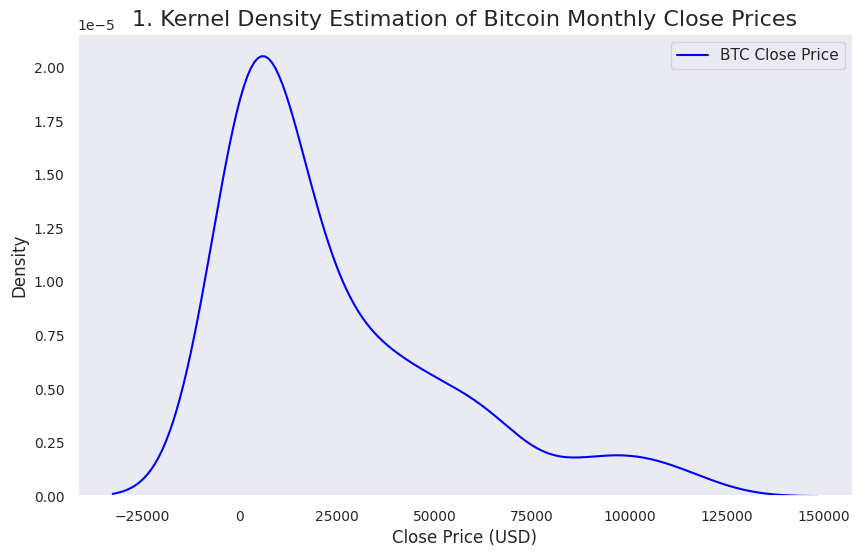

Inference 1: KDE plot shows the distribution of monthly close prices. If multiple peaks appear, it suggests periods of different price regimes or volatility. A smooth unimodal shape would indicate a relatively consistent distribution over time.



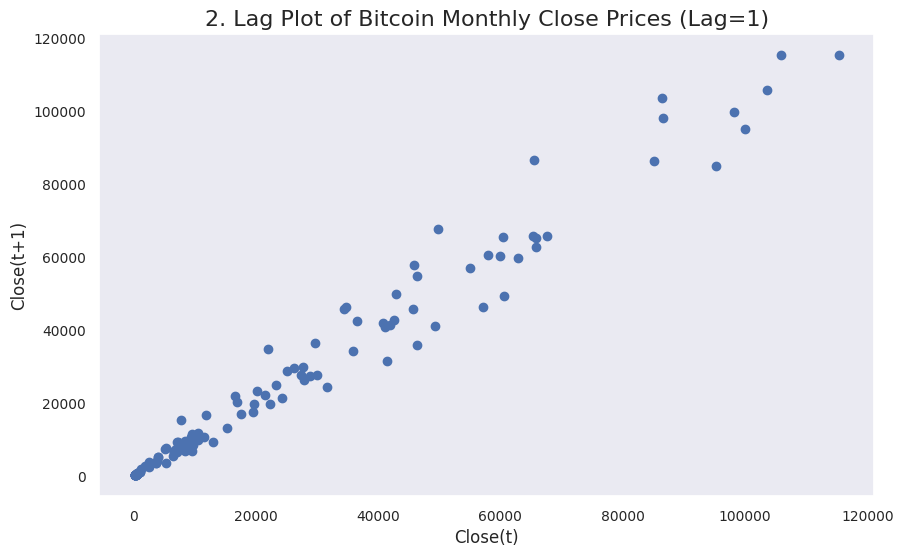

Inference 2: Lag plot helps identify autocorrelation. A clear diagonal pattern implies strong positive autocorrelation between consecutive months, meaning current prices tend to be similar to the previous month's prices.



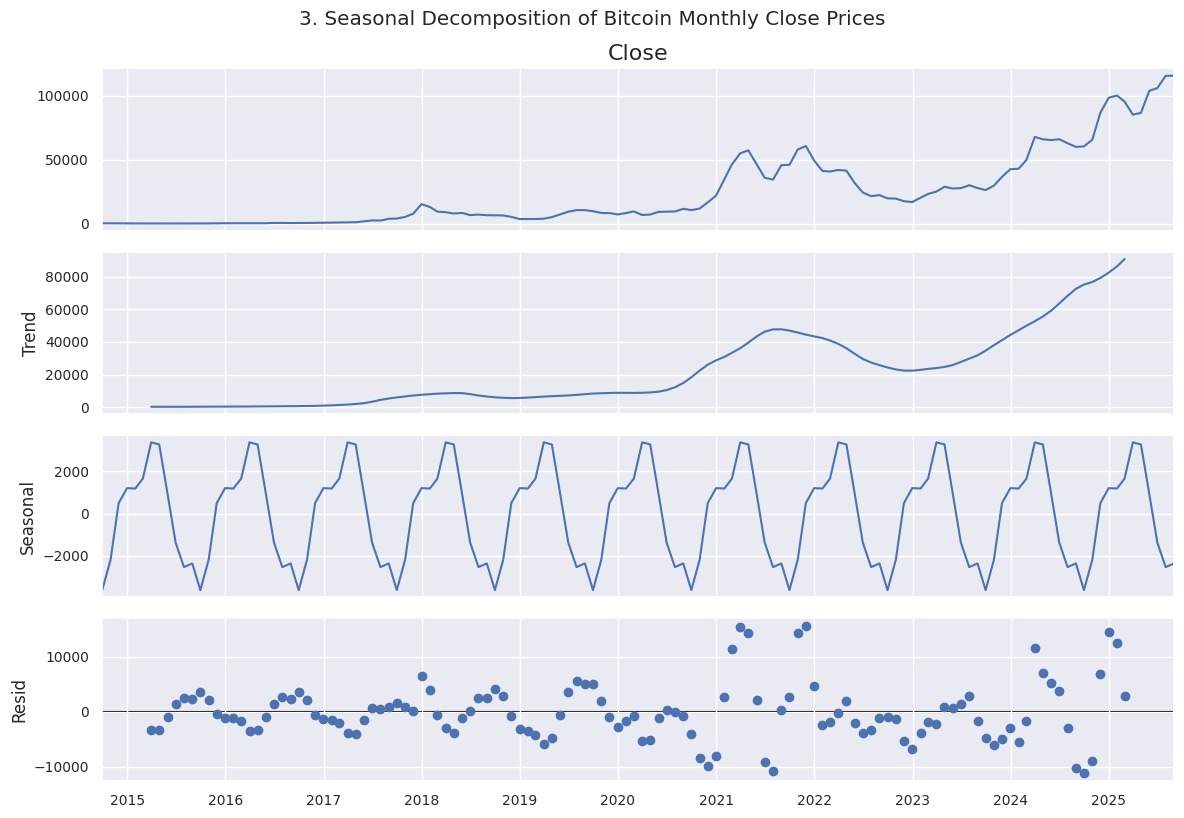

Inference 3: Seasonal decomposition separates trend, seasonal, and residual components. If the seasonal component is near zero or noisy, it suggests weak or no seasonality in monthly prices. Trend shows overall growth or decline, and residual captures irregularities.



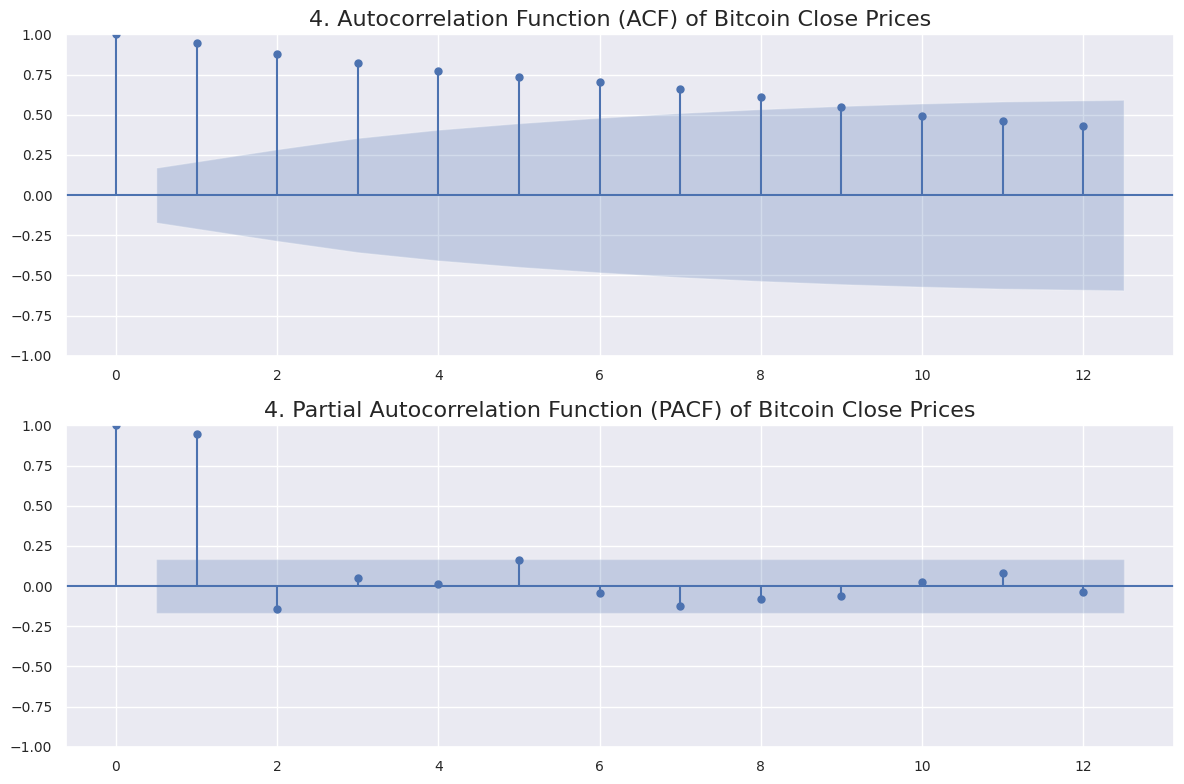

Inference 4: ACF plot shows correlation of prices with their past values. Slow decay indicates non-stationarity, while sharp cutoff implies stationarity. PACF helps identify significant lag orders for modeling AR terms in time series.

5. ADF Test Results:
ADF Statistic: 0.3770
p-value: 0.9806
Critical Values: {'1%': np.float64(-3.4851223522012855), '5%': np.float64(-2.88553750045158), '10%': np.float64(-2.5795685622144586)}
Result: Fail to reject null hypothesis - Time series is likely non-stationary

5. KPSS Test Results:
KPSS Statistic: 1.4787
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Result: Reject null hypothesis - Time series is likely non-stationary

Inference 5: Stationarity tests give complementary results. ADF tests for unit root (non-stationarity), while KPSS tests for trend stationarity. If both suggest non-stationarity, differencing or transformation may be needed for modeling.

6. Sample of Engineered Features:
              

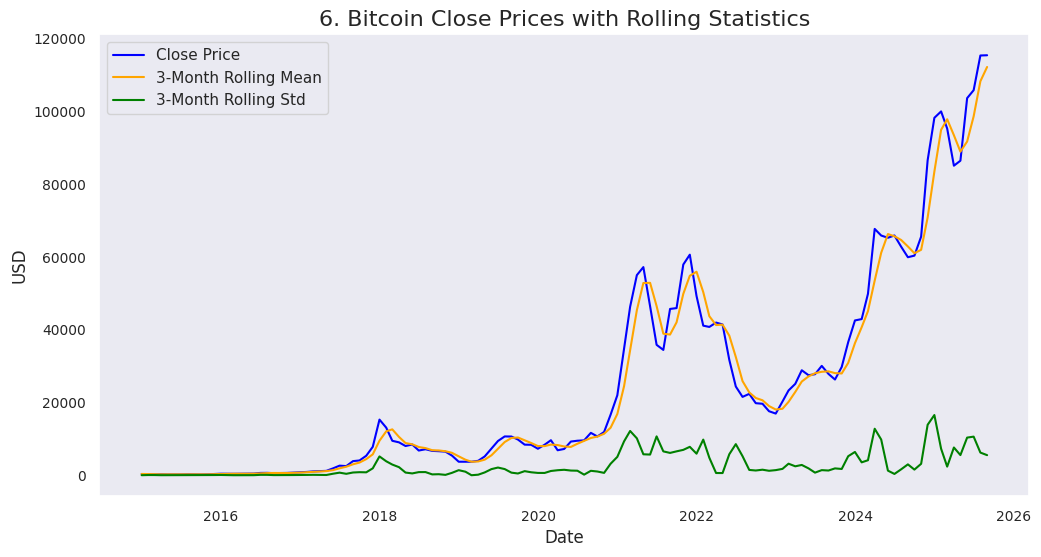

Inference 6: Rolling mean smooths short-term fluctuations showing the underlying trend, while rolling std shows volatility over time. Increasing rolling std indicates higher price variability.



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
import warnings
warnings.filterwarnings('ignore')

# Set Seaborn style
sns.set_style('darkgrid')
sns.set(rc={"figure.figsize": (12, 8), "axes.titlesize": 16, "axes.labelsize": 12,
            "xtick.labelsize": 10, "ytick.labelsize": 10})

# Convert btc index to DatetimeIndex
btc.index = pd.to_datetime(btc.index)

# Resample to monthly frequency, taking the mean of the 'Close' column
btc_month = btc['Close'].resample('M').mean()

# 1. Kernel Density Estimation (KDE) Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(btc_month, label='BTC Close Price', color='blue')
plt.title('1. Kernel Density Estimation of Bitcoin Monthly Close Prices')
plt.xlabel('Close Price (USD)')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

print("Inference 1: KDE plot shows the distribution of monthly close prices. "
      "If multiple peaks appear, it suggests periods of different price regimes or volatility. "
      "A smooth unimodal shape would indicate a relatively consistent distribution over time.\n")

# 2. Lag Plot
plt.figure(figsize=(10, 6))
lag_plot(btc_month, lag=1)
plt.title('2. Lag Plot of Bitcoin Monthly Close Prices (Lag=1)')
plt.xlabel('Close(t)')
plt.ylabel('Close(t+1)')
plt.grid()
plt.show()

print("Inference 2: Lag plot helps identify autocorrelation. "
      "A clear diagonal pattern implies strong positive autocorrelation between consecutive months, "
      "meaning current prices tend to be similar to the previous month's prices.\n")

# 3. Seasonal Decomposition (Trend, Seasonal, Residual)
decomposition = seasonal_decompose(btc_month, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('3. Seasonal Decomposition of Bitcoin Monthly Close Prices', y=1.02)
plt.show()

print("Inference 3: Seasonal decomposition separates trend, seasonal, and residual components. "
      "If the seasonal component is near zero or noisy, it suggests weak or no seasonality in monthly prices. "
      "Trend shows overall growth or decline, and residual captures irregularities.\n")

# 4. Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(btc_month, lags=12, ax=ax1)
ax1.set_title('4. Autocorrelation Function (ACF) of Bitcoin Close Prices')
plot_pacf(btc_month, lags=12, ax=ax2)
ax2.set_title('4. Partial Autocorrelation Function (PACF) of Bitcoin Close Prices')
plt.tight_layout()
plt.show()

print("Inference 4: ACF plot shows correlation of prices with their past values. "
      "Slow decay indicates non-stationarity, while sharp cutoff implies stationarity. "
      "PACF helps identify significant lag orders for modeling AR terms in time series.\n")

# 5. Stationarity Tests
# Augmented Dickey-Fuller (ADF) Test
adf_result = adfuller(btc_month)
print("5. ADF Test Results:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:", adf_result[4])
if adf_result[1] > 0.05:
    print("Result: Fail to reject null hypothesis - Time series is likely non-stationary")
else:
    print("Result: Reject null hypothesis - Time series is likely stationary")

# KPSS Test
kpss_result = kpss(btc_month, regression='c')
print("\n5. KPSS Test Results:")
print(f"KPSS Statistic: {kpss_result[0]:.4f}")
print(f"p-value: {kpss_result[1]:.4f}")
print("Critical Values:", kpss_result[3])
if kpss_result[1] < 0.05:
    print("Result: Reject null hypothesis - Time series is likely non-stationary")
else:
    print("Result: Fail to reject null hypothesis - Time series is likely stationary")

print("\nInference 5: Stationarity tests give complementary results. "
      "ADF tests for unit root (non-stationarity), while KPSS tests for trend stationarity. "
      "If both suggest non-stationarity, differencing or transformation may be needed for modeling.\n")

# 6. Engineer Lag Features and Rolling Statistics
# Create lag features (1 to 3 months)
btc_month_df = pd.DataFrame(btc_month, columns=['Close'])
for lag in range(1, 4):
    btc_month_df[f'lag_{lag}'] = btc_month_df['Close'].shift(lag)

# Rolling mean and standard deviation (window=3 months)
btc_month_df['rolling_mean_3'] = btc_month_df['Close'].rolling(window=3).mean()
btc_month_df['rolling_std_3'] = btc_month_df['Close'].rolling(window=3).std()

# Drop NaN values for clean output
btc_month_df = btc_month_df.dropna()

# Display sample of engineered features
print("6. Sample of Engineered Features:")
print(btc_month_df.head())

# Plot Rolling Statistics
plt.figure(figsize=(12, 6))
plt.plot(btc_month_df['Close'], label='Close Price', color='blue')
plt.plot(btc_month_df['rolling_mean_3'], label='3-Month Rolling Mean', color='orange')
plt.plot(btc_month_df['rolling_std_3'], label='3-Month Rolling Std', color='green')
plt.title('6. Bitcoin Close Prices with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid()
plt.show()

print("Inference 6: Rolling mean smooths short-term fluctuations showing the underlying trend, "
      "while rolling std shows volatility over time. Increasing rolling std indicates higher price variability.\n")


# ARIMA

Best ARIMA order: (1, 1, 0), AIC: 340.39
                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                  132
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -168.196
Date:                Tue, 12 Aug 2025   AIC                            340.391
Time:                        13:45:49   BIC                            346.142
Sample:                    09-30-2014   HQIC                           342.728
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4295      0.058      7.466      0.000       0.317       0.542
sigma2         0.7622      0.081      9.397      0.000       0.603       0.921
Ljung-Box (

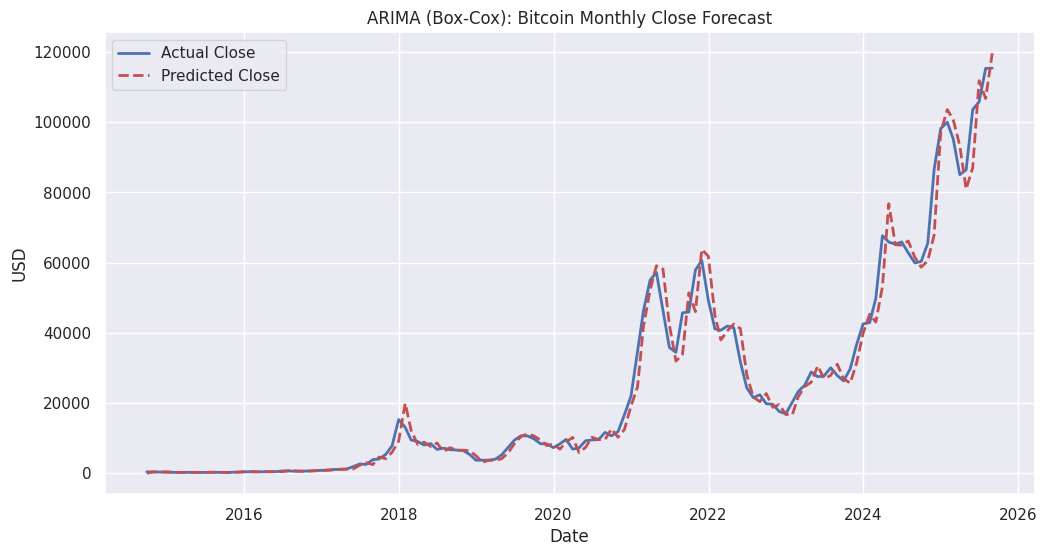

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('darkgrid')
sns.set(rc={"figure.figsize": (12, 8)})

# Inverse Box-Cox
def invboxcox(y, lmbda):
    return np.exp(np.log(lmbda * y + 1) / lmbda) if lmbda != 0 else np.exp(y)

# Ensure datetime index
btc.index = pd.to_datetime(btc.index)

# Monthly average close price
btc_month = btc['Close'].resample('M').mean().sort_index()

# Box–Cox transform
btc_month_df = pd.DataFrame(btc_month, columns=['Close'])
btc_month_df['close_box'], lmbda = stats.boxcox(btc_month_df['Close'])

# Parameter search ranges
p = range(0, 4)
d = range(0, 3)
q = range(0, 4)
parameters = product(p, d, q)

best_aic = float("inf")
best_order = None
best_model = None

# Grid search
for order in parameters:
    try:
        model = SARIMAX(btc_month_df['close_box'], order=order).fit(disp=False)
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except:
        continue

print(f"Best ARIMA order: {best_order}, AIC: {best_aic:.2f}")
print(best_model.summary())

# Forecast horizon (same length as data for comparison + extra months)
forecast_dates = pd.date_range(start=btc_month_df.index[0],
                                end='2025-08-31', freq='M')
btc_month_pred = pd.DataFrame(index=forecast_dates, columns=['Close'])
btc_month_pred['Close'] = btc_month.reindex(forecast_dates)

# Predict in Box–Cox space and invert
forecast_boxcox = best_model.predict(start=0, end=len(btc_month_pred)-1)
btc_month_pred['forecast'] = invboxcox(forecast_boxcox, lmbda)

# Validation window
validation_idx = (btc_month_pred.index >= '2015-01-01') & (btc_month_pred.index <= '2017-01-01')
y_true = btc_month_pred.loc[validation_idx, 'Close']
y_pred = btc_month_pred.loc[validation_idx, 'forecast']

# Drop NaNs
valid_idx = ~(y_true.isna() | y_pred.isna())
y_true = y_true[valid_idx]
y_pred = y_pred[valid_idx]

# Metrics
rmse = sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(btc_month_pred['Close'], label='Actual Close', linewidth=2)
plt.plot(btc_month_pred['forecast'], '--r', label='Predicted Close', linewidth=2)
plt.title('ARIMA (Box-Cox): Bitcoin Monthly Close Forecast')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.show()


# SARIMAX

Best SARIMAX order: (0, 1, 2), seasonal_order: (0, 1, 1, 12), AIC: 306.25
                                      SARIMAX Results                                       
Dep. Variable:                            close_box   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -149.127
Date:                              Tue, 12 Aug 2025   AIC                            306.253
Time:                                      14:15:58   BIC                            316.831
Sample:                                  09-30-2014   HQIC                           310.538
                                       - 08-31-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4630   

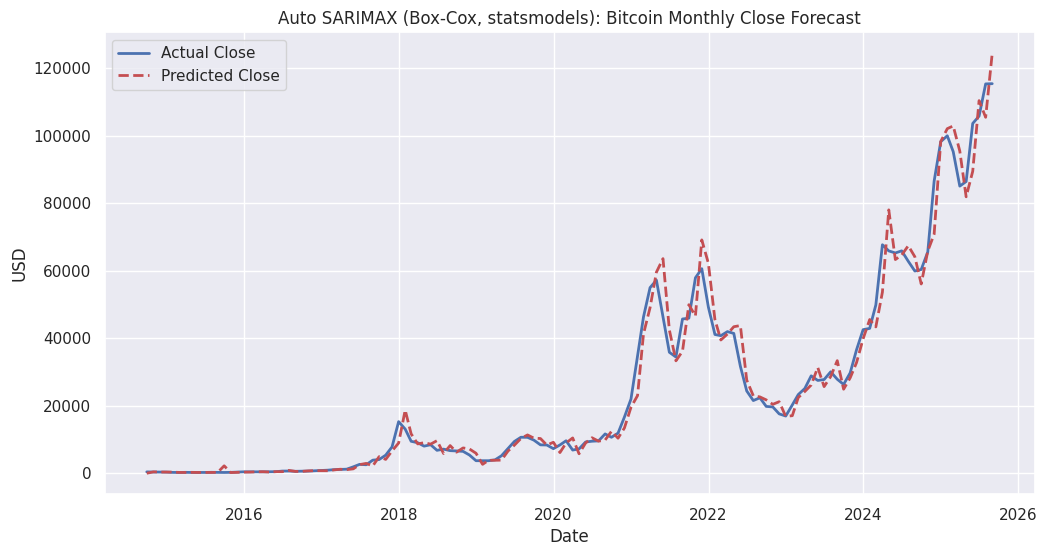

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Style
sns.set_style('darkgrid')
sns.set(rc={"figure.figsize": (12, 8)})

# Inverse Box–Cox
def invboxcox(y, lmbda):
    return np.exp(np.log(lmbda * y + 1) / lmbda) if lmbda != 0 else np.exp(y)

# Ensure datetime index
btc.index = pd.to_datetime(btc.index)

# Monthly average close price
btc_month = btc['Close'].resample('M').mean().sort_index()

# Box–Cox transform
btc_month_df = pd.DataFrame(btc_month, columns=['Close'])
btc_month_df['close_box'], lmbda = stats.boxcox(btc_month_df['Close'])

# Search ranges
p = d = q = range(0, 3)          # smaller range for speed
P = D = Q = range(0, 2)          # seasonal params
s = 12                           # yearly seasonality

best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

# Grid search
for order in product(p, d, q):
    for seasonal_order in product(P, D, Q, [s]):
        try:
            model = SARIMAX(btc_month_df['close_box'],
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit(disp=False)
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = model
        except:
            continue

print(f"Best SARIMAX order: {best_order}, seasonal_order: {best_seasonal_order}, AIC: {best_aic:.2f}")
print(best_model.summary())

# Forecast horizon
forecast_dates = pd.date_range(start=btc_month_df.index[0], end='2025-08-31', freq='M')
btc_month_pred = pd.DataFrame(index=forecast_dates, columns=['Close'])
btc_month_pred['Close'] = btc_month.reindex(forecast_dates)

# Predict & invert Box–Cox
forecast_boxcox = best_model.predict(start=0, end=len(btc_month_pred)-1)
btc_month_pred['forecast'] = invboxcox(forecast_boxcox, lmbda)

# Validation window
validation_idx = (btc_month_pred.index >= '2015-01-01') & (btc_month_pred.index <= '2017-01-01')
y_true = btc_month_pred.loc[validation_idx, 'Close']
y_pred = btc_month_pred.loc[validation_idx, 'forecast']

# Drop NaNs
valid_idx = ~(y_true.isna() | y_pred.isna())
y_true = y_true[valid_idx]
y_pred = y_pred[valid_idx]

# Metrics
rmse = sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(btc_month_pred['Close'], label='Actual Close', linewidth=2)
plt.plot(btc_month_pred['forecast'], '--r', label='Predicted Close', linewidth=2)
plt.title('Auto SARIMAX (Box-Cox, statsmodels): Bitcoin Monthly Close Forecast')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.show()


# Facebook Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxfefmaq3/6wvntzpy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxfefmaq3/vqlyyrg0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27920', 'data', 'file=/tmp/tmpxfefmaq3/6wvntzpy.json', 'init=/tmp/tmpxfefmaq3/vqlyyrg0.json', 'output', 'file=/tmp/tmpxfefmaq3/prophet_modelc65o01cl/prophet_model-20250812163839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:38:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:38:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Estimated Box-Cox lambda: 0.1812
RMSE: 357.69
MAE: 296.57
MAPE: 65.17%


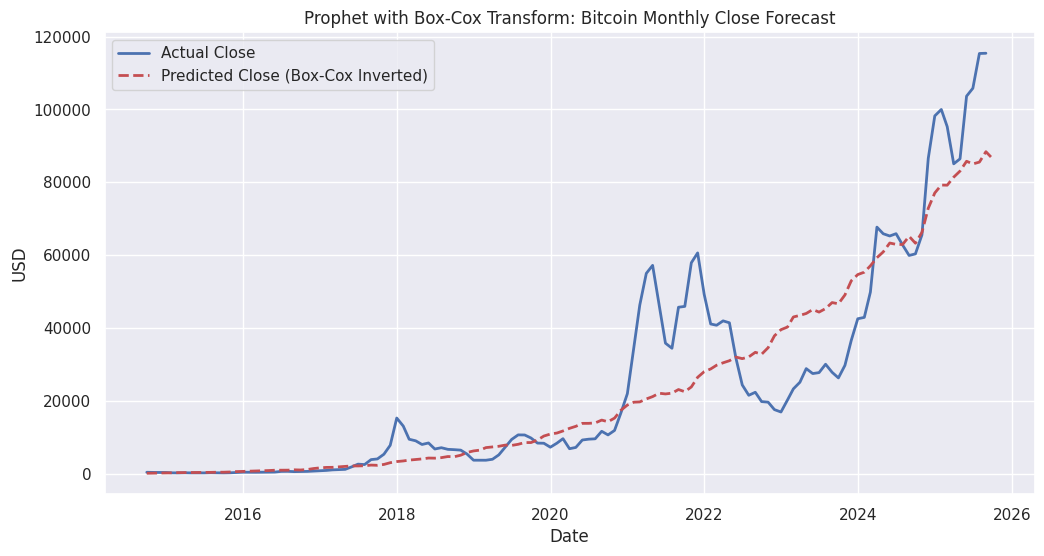

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from prophet import Prophet
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('darkgrid')
sns.set(rc={"figure.figsize": (12, 8)})

# Ensure datetime index
btc.index = pd.to_datetime(btc.index)

# Monthly average close price
btc_month = btc['Close'].resample('M').mean().sort_index()

# Box-Cox transform (find lambda and transform y)
btc_month_positive = btc_month + 1e-6  # to avoid zeros if any
btc_month_boxcox, lmbda = stats.boxcox(btc_month_positive)

# Prepare DataFrame for Prophet with Box-Cox transformed target
df_prophet = pd.DataFrame({
    'ds': btc_month.index,
    'y': btc_month_boxcox
})

print(f"Estimated Box-Cox lambda: {lmbda:.4f}")

# Fit Prophet on transformed data
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(df_prophet)

# Forecast horizon
last_date = btc_month.index[-1]
periods = (pd.Timestamp('2025-08-31').to_period('M') - last_date.to_period('M')).n + 1
future_dates = model.make_future_dataframe(periods=periods, freq='M')

# Predict in Box-Cox space
forecast = model.predict(future_dates)

# Inverse Box-Cox function
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.power(lmbda * y + 1, 1 / lmbda)

# Apply inverse Box-Cox to predictions
forecast['yhat_inv'] = inv_boxcox(forecast['yhat'], lmbda)

# Merge actual and forecast for metrics & plotting
forecast_df = forecast.set_index('ds')[['yhat_inv']]
btc_month_pred = btc_month.to_frame().join(forecast_df, how='outer').rename(columns={'Close': 'Actual', 'yhat_inv': 'Forecast'})

# Validation window (2015-01-01 to 2017-01-01)
validation_idx = (btc_month_pred.index >= '2015-01-01') & (btc_month_pred.index <= '2017-01-01')
y_true = btc_month_pred.loc[validation_idx, 'Actual']
y_pred = btc_month_pred.loc[validation_idx, 'Forecast']

# Drop NaNs for metrics calculation
valid_idx = ~(y_true.isna() | y_pred.isna())
y_true = y_true[valid_idx]
y_pred = y_pred[valid_idx]

# Metrics
rmse = sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(btc_month_pred['Actual'], label='Actual Close', linewidth=2)
plt.plot(btc_month_pred['Forecast'], '--r', label='Predicted Close (Box-Cox Inverted)', linewidth=2)
plt.title('Prophet with Box-Cox Transform: Bitcoin Monthly Close Forecast')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.show()
